# Import Libraries 

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings("ignore")

# Load Data

In [35]:
df_train = pd.read_csv(r'C:\Users\dell\Desktop\ELEVVO INTERN\Sales Forecasting Description\Merged Data\Merged_Train.csv')
df_test = pd.read_csv(r'C:\Users\dell\Desktop\ELEVVO INTERN\Sales Forecasting Description\Merged Data\Merged_Test.csv')

In [36]:
df_train.columns

Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Type', 'Size', 'Weekly_Sales'],
      dtype='object')

In [37]:
df_train.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Weekly_Sales
0,1,1,2010-02-05,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,24924.50
1,1,1,2010-02-12,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,46039.49
2,1,1,2010-02-19,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,41595.55
3,1,1,2010-02-26,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,19403.54
4,1,1,2010-03-05,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,21827.90


# Fixing Data types

In [38]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

# Time aware validation split

In [39]:
# sort by date
df_train = df_train.sort_values('Date')
df_test = df_test.sort_values('Date')

In [40]:
# seperate features and target variable
x_sorted = df_train.drop('Weekly_Sales', axis=1)
y_sorted = df_train['Weekly_Sales']
x_test_sorted = df_test.copy()

In [41]:
# time-based split (80% train, 20% validation)
split_index = int(len(x_sorted) * 0.8)

x_train_time = x_sorted.iloc[:split_index]
y_train_time = y_sorted.iloc[:split_index]

x_val_time = x_sorted.iloc[split_index:]
y_val_time = y_sorted.iloc[split_index:]

# Handling Outliers

In [42]:
num_cols = x_train_time.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = x_train_time.select_dtypes(include=["object", "category"]).columns.tolist()

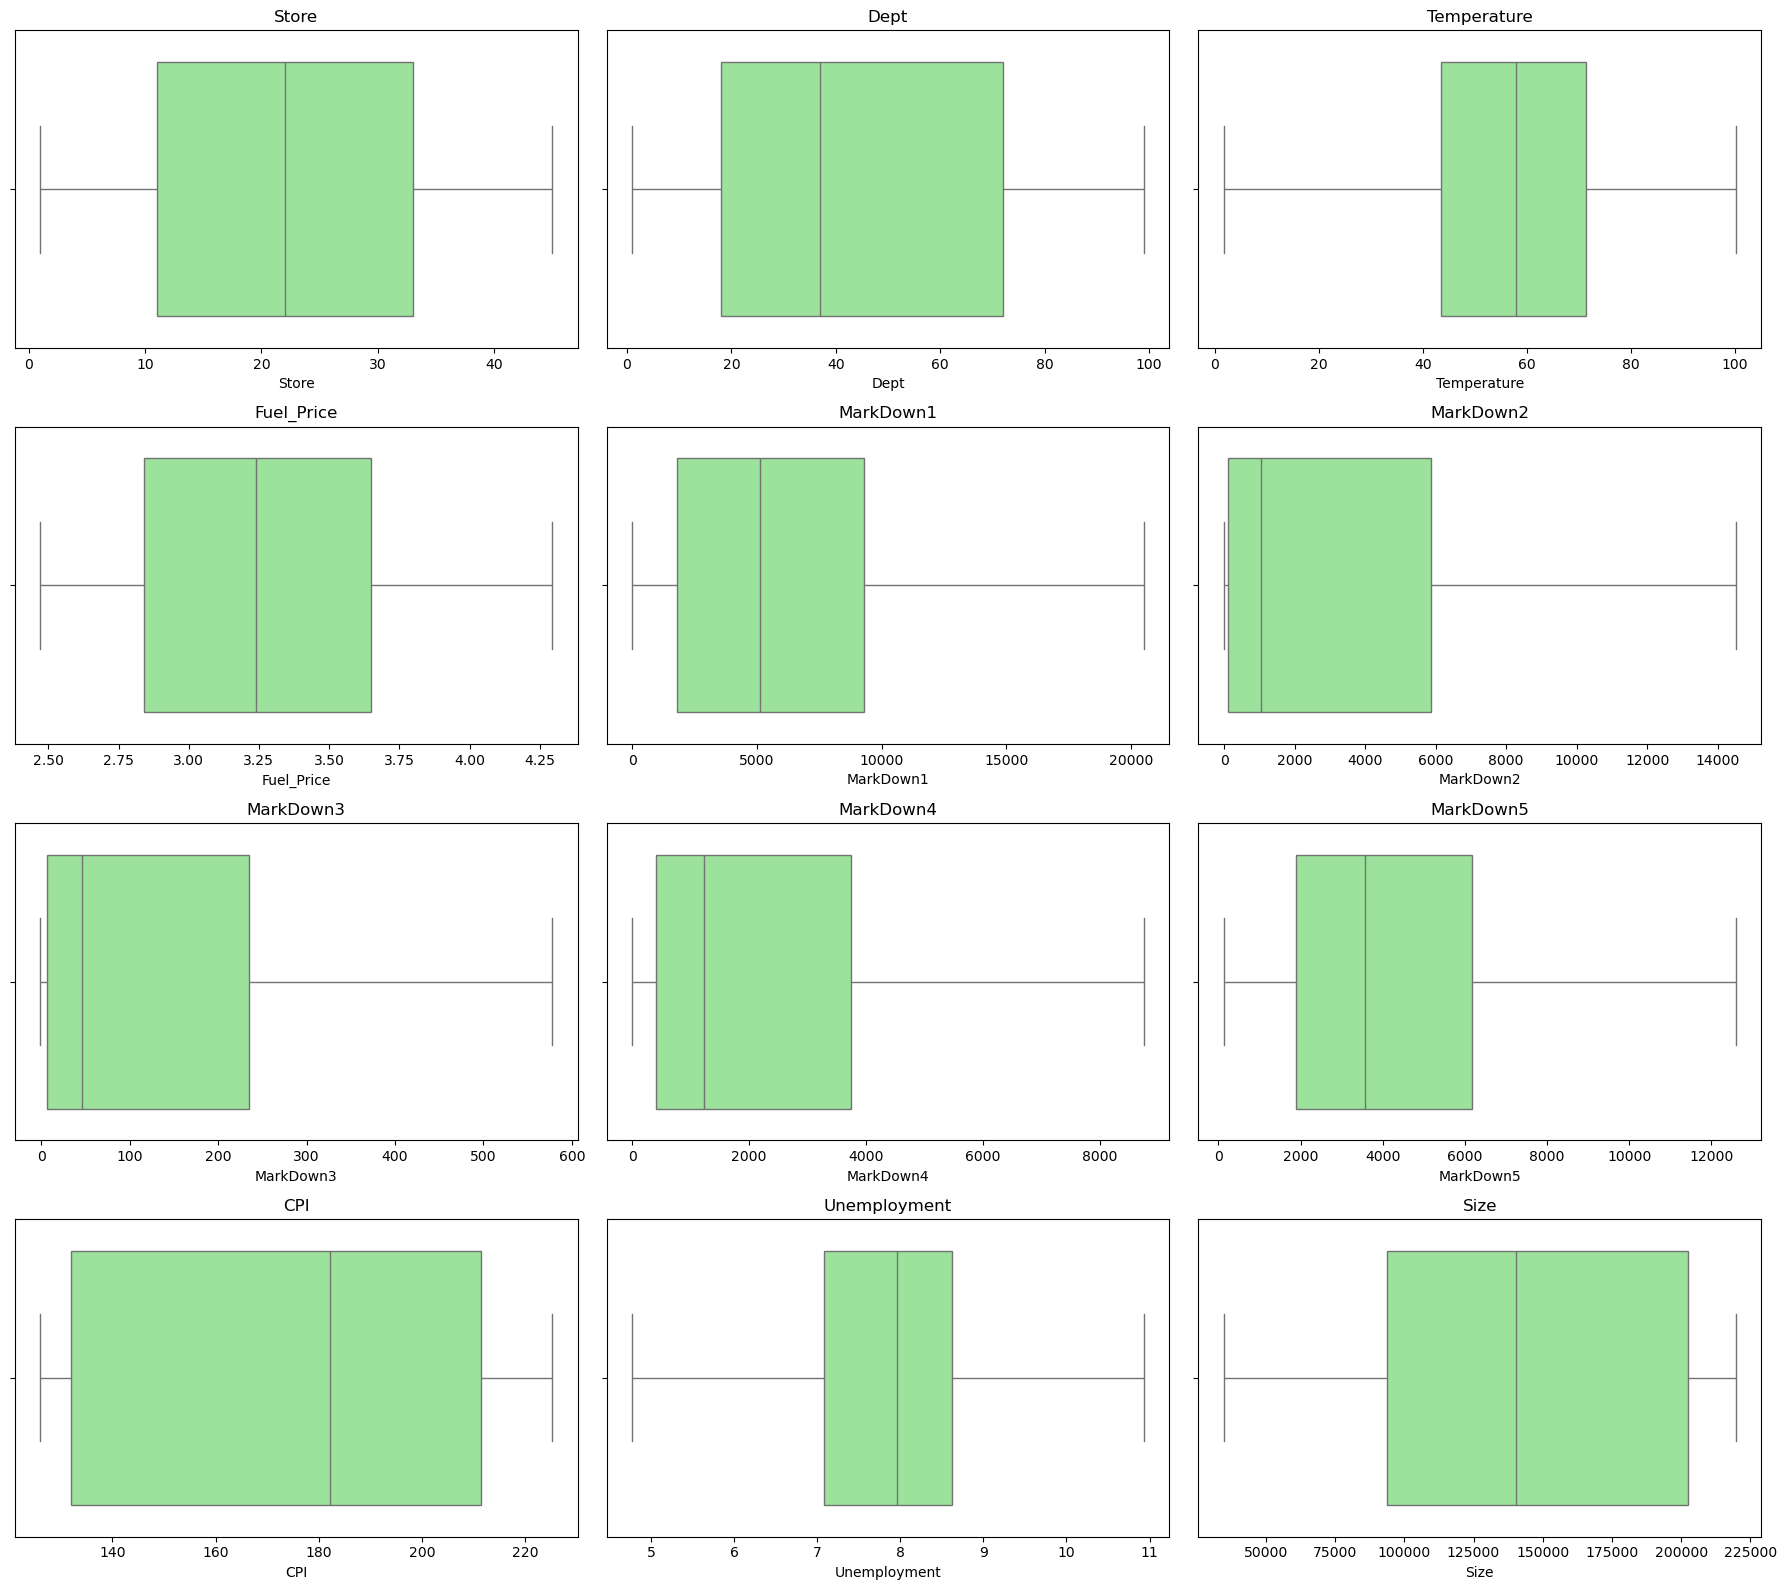

In [43]:
for col in num_cols:
    Q1 = x_train_time[col].quantile(0.25)
    Q3 = x_train_time[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap values
    x_train_time[col] = np.where(x_train_time[col] < lower_bound, lower_bound,np.where(x_train_time[col] > upper_bound, upper_bound, x_train_time[col]))
    x_val_time[col] = np.where(x_val_time[col] < lower_bound, lower_bound,np.where(x_val_time[col] > upper_bound, upper_bound, x_val_time[col]))
    x_test_sorted[col] = np.where(x_test_sorted[col] < lower_bound, lower_bound,np.where(x_test_sorted[col] > upper_bound, upper_bound, x_test_sorted[col]))

# After handling outliers plot
n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)

plt.figure(figsize=(n_cols * 6, n_rows * 4))

for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=x_train_time[col], color='lightgreen')
    plt.title(f'{col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

# Filling Missing Values

In [44]:
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    mean_val = x_train_time[col].mean()
    x_train_time[col] = x_train_time[col].fillna(mean_val)
    x_val_time[col] = x_val_time[col].fillna(mean_val)
    x_test_sorted[col] = x_test_sorted[col].fillna(mean_val)

In [45]:
x_train_time.isnull().sum()

Store           0
Dept            0
Date            0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

# Encode Categorical & Boolean Data

In [46]:
encoded_cols = ['Type', 'IsHoliday']
encoders = {}

for col in encoded_cols:
    le = LabelEncoder()
    x_train_time[col] = le.fit_transform(x_train_time[col])
    x_val_time[col] = le.transform(x_val_time[col])
    x_test_sorted[col] = le.transform(x_test_sorted[col])
    encoders[col] = le 

In [47]:
x_train_time.info()

<class 'pandas.core.frame.DataFrame'>
Index: 337256 entries, 0 to 237783
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         337256 non-null  float64       
 1   Dept          337256 non-null  float64       
 2   Date          337256 non-null  datetime64[ns]
 3   IsHoliday     337256 non-null  int64         
 4   Temperature   337256 non-null  float64       
 5   Fuel_Price    337256 non-null  float64       
 6   MarkDown1     337256 non-null  float64       
 7   MarkDown2     337256 non-null  float64       
 8   MarkDown3     337256 non-null  float64       
 9   MarkDown4     337256 non-null  float64       
 10  MarkDown5     337256 non-null  float64       
 11  CPI           337256 non-null  float64       
 12  Unemployment  337256 non-null  float64       
 13  Type          337256 non-null  int32         
 14  Size          337256 non-null  float64       
dtypes: datetime64[ns](1), 

# Feature Engineering

In [48]:
# Date Based Features
x_train_time['Year'] = x_train_time['Date'].dt.year
x_train_time['Month'] = x_train_time['Date'].dt.month
x_train_time['Week'] = x_train_time['Date'].dt.isocalendar().week
x_train_time['Day'] = x_train_time['Date'].dt.day
x_train_time['DayOfWeek'] = x_train_time['Date'].dt.dayofweek
x_train_time['Quarter'] = x_train_time['Date'].dt.quarter

x_val_time['Year'] = x_val_time['Date'].dt.year
x_val_time['Month'] = x_val_time['Date'].dt.month
x_val_time['Week'] = x_val_time['Date'].dt.isocalendar().week
x_val_time['Day'] = x_val_time['Date'].dt.day
x_val_time['DayOfWeek'] = x_val_time['Date'].dt.dayofweek
x_val_time['Quarter'] = x_val_time['Date'].dt.quarter

x_test_sorted['Year'] = x_test_sorted['Date'].dt.year
x_test_sorted['Month'] = x_test_sorted['Date'].dt.month
x_test_sorted['Week'] = x_test_sorted['Date'].dt.isocalendar().week
x_test_sorted['Day'] = x_test_sorted['Date'].dt.day
x_test_sorted['DayOfWeek'] = x_test_sorted['Date'].dt.dayofweek
x_test_sorted['Quarter'] = x_test_sorted['Date'].dt.quarter

In [49]:
#  Holiday proximity features
x_train_time['DaysToHoliday'] = x_train_time.groupby(['Store', 'Dept'])['IsHoliday'].transform(lambda x: x[::-1].cumsum()[::-1])
x_val_time['DaysToHoliday'] = x_val_time.groupby(['Store', 'Dept'])['IsHoliday'].transform(lambda x: x[::-1].cumsum()[::-1])
x_test_sorted['DaysToHoliday'] = x_test_sorted.groupby(['Store', 'Dept'])['IsHoliday'].transform(lambda x: x[::-1].cumsum()[::-1])


# MarkDown total
x_train_time['MarkDown_Total'] = x_train_time[markdown_cols].sum(axis=1)
x_val_time['MarkDown_Total'] = x_val_time[markdown_cols].sum(axis=1)
x_test_sorted['MarkDown_Total'] = x_test_sorted[markdown_cols].sum(axis=1)

x_train_time = x_train_time.drop(columns=markdown_cols, axis=1)
x_val_time = x_val_time.drop(columns=markdown_cols, axis=1)
x_test_sorted = x_test_sorted.drop(columns=markdown_cols, axis=1)

In [50]:
# Historical Averages 
historical_means = x_train_time.groupby(['Store', 'Dept']).agg({'Temperature': 'mean','Fuel_Price': 'mean', 'MarkDown_Total': 'mean','CPI': 'mean','Unemployment': 'mean'}).add_prefix('Historical_Avg_')

x_train_time = x_train_time.merge(historical_means, on=['Store', 'Dept'], how='left')
x_val_time = x_val_time.merge(historical_means, on=['Store', 'Dept'], how='left')
x_test_sorted = x_test_sorted.merge(historical_means, on=['Store', 'Dept'], how='left')

# To prevent nulls
global_avgs = x_train_time.filter(like='Historical_Avg_').mean()  
x_val_time = x_val_time.fillna(global_avgs)
x_test_sorted = x_test_sorted.fillna(global_avgs)

In [51]:
# Calculate changes
x_train_time['FuelPrice_Change'] = x_train_time.groupby(['Store', 'Dept'])['Fuel_Price'].diff()
x_val_time['FuelPrice_Change'] = x_val_time.groupby(['Store', 'Dept'])['Fuel_Price'].diff()
x_test_sorted['FuelPrice_Change'] = x_test_sorted.groupby(['Store', 'Dept'])['Fuel_Price'].diff()

x_train_time['Temperature_Change'] = x_train_time.groupby(['Store', 'Dept'])['Temperature'].diff()
x_val_time['Temperature_Change'] = x_val_time.groupby(['Store', 'Dept'])['Temperature'].diff()
x_test_sorted['Temperature_Change'] = x_test_sorted.groupby(['Store', 'Dept'])['Temperature'].diff()

# Fill nulls - first try group mean, then overall mean as fallback
for df in [x_train_time,x_val_time, x_test_sorted]:
    for col in ['FuelPrice_Change', 'Temperature_Change']:
        group_means = df.groupby(['Store', 'Dept'])[col].transform('mean')
        overall_mean = df[col].mean()
        df[col] = df[col].fillna(group_means).fillna(overall_mean).fillna(0)

In [52]:
# Create "pseudo-lag" features using available data
x_train_time['Prev_IsHoliday'] = x_train_time.groupby(['Store', 'Dept'])['IsHoliday'].shift(1)
x_train_time['Prev_Temperature'] = x_train_time.groupby(['Store', 'Dept'])['Temperature'].shift(1)
x_train_time['Prev_MarkDown'] = x_train_time.groupby(['Store', 'Dept'])['MarkDown_Total'].shift(1)

# Fill nulls with appropriate values
for col in ['Prev_IsHoliday', 'Prev_Temperature', 'Prev_MarkDown']:
    x_train_time[col] = x_train_time[col].fillna(x_train_time[col].mean())
    
x_val_time['Prev_IsHoliday'] = x_val_time.groupby(['Store', 'Dept'])['IsHoliday'].shift(1)
x_val_time['Prev_Temperature'] = x_val_time.groupby(['Store', 'Dept'])['Temperature'].shift(1)
x_val_time['Prev_MarkDown'] = x_val_time.groupby(['Store', 'Dept'])['MarkDown_Total'].shift(1)

# Fill nulls with appropriate values
for col in ['Prev_IsHoliday', 'Prev_Temperature', 'Prev_MarkDown']:
    x_val_time[col] = x_val_time[col].fillna(x_val_time[col].mean())
    
x_test_sorted['Prev_IsHoliday'] = x_test_sorted.groupby(['Store', 'Dept'])['IsHoliday'].shift(1)
x_test_sorted['Prev_Temperature'] = x_test_sorted.groupby(['Store', 'Dept'])['Temperature'].shift(1)
x_test_sorted['Prev_MarkDown'] = x_test_sorted.groupby(['Store', 'Dept'])['MarkDown_Total'].shift(1)

# Fill nulls with appropriate values
for col in ['Prev_IsHoliday', 'Prev_Temperature', 'Prev_MarkDown']:
    x_test_sorted[col] = x_test_sorted[col].fillna(x_test_sorted[col].mean())

In [53]:
# Rolling averages of measurable features
for window in [4, 8, 12, 26, 52]:  
    x_train_time[f'Temperature_Rolling{window}'] = x_train_time.groupby(['Store', 'Dept'])['Temperature'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    
    x_train_time[f'FuelPrice_Rolling{window}'] = x_train_time.groupby(['Store', 'Dept'])['Fuel_Price'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    
    x_train_time[f'MarkDown_Rolling{window}'] = x_train_time.groupby(['Store', 'Dept'])['MarkDown_Total'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    
    x_val_time[f'Temperature_Rolling{window}'] = x_val_time.groupby(['Store', 'Dept'])['Temperature'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    
    x_val_time[f'FuelPrice_Rolling{window}'] = x_val_time.groupby(['Store', 'Dept'])['Fuel_Price'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    
    x_val_time[f'MarkDown_Rolling{window}'] = x_val_time.groupby(['Store', 'Dept'])['MarkDown_Total'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    
    x_test_sorted[f'Temperature_Rolling{window}'] = x_test_sorted.groupby(['Store', 'Dept'])['Temperature'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    
    x_test_sorted[f'FuelPrice_Rolling{window}'] = x_test_sorted.groupby(['Store', 'Dept'])['Fuel_Price'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    
    x_test_sorted[f'MarkDown_Rolling{window}'] = x_test_sorted.groupby(['Store', 'Dept'])['MarkDown_Total'].transform(lambda x: x.rolling(window, min_periods=1).mean())


In [54]:
x_train_time.drop(columns=['Date'], inplace=True)
x_val_time.drop(columns=['Date'], inplace=True)
x_test_sorted.drop(columns=['Date'], inplace=True)

# Load Preprocessed Data

In [55]:
# Reset indices to ensure alignment
x_train_reset = x_train_time.reset_index(drop=True)
y_train_reset = y_train_time.reset_index(drop=True)
x_val_reset = x_val_time.reset_index(drop=True)
y_val_reset = y_val_time.reset_index(drop=True)
x_test_reset = x_test_sorted.reset_index(drop=True)

df_preprocessed_train = pd.concat([x_train_reset, y_train_reset], axis=1)
df_preprocessed_val = pd.concat([x_val_reset, y_val_reset], axis=1)
df_preprocessed_test = x_test_reset.copy()  

df_preprocessed_train.to_csv(r'C:\Users\dell\Desktop\ELEVVO INTERN\Sales Forecasting Description\PreProcessed Data\Preprocessed_Train.csv', index=False)
df_preprocessed_val.to_csv(r'C:\Users\dell\Desktop\ELEVVO INTERN\Sales Forecasting Description\PreProcessed Data\Preprocessed_Val.csv', index=False)
df_preprocessed_test.to_csv(r'C:\Users\dell\Desktop\ELEVVO INTERN\Sales Forecasting Description\PreProcessed Data\Preprocessed_Test.csv', index=False)

In [56]:
df_preprocessed_train.tail()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Year,...,Temperature_Rolling12,FuelPrice_Rolling12,MarkDown_Rolling12,Temperature_Rolling26,FuelPrice_Rolling26,MarkDown_Rolling26,Temperature_Rolling52,FuelPrice_Rolling52,MarkDown_Rolling52,Weekly_Sales
337251,23.0,81.0,0,41.81,4.025,137.868000,4.772,1,114533.0,2012,...,34.510833,3.806000,22105.791714,34.767308,3.649692,19209.498987,48.556923,3.757558,18358.437579,7114.08
337252,23.0,80.0,0,41.81,4.025,137.868000,4.772,1,114533.0,2012,...,34.510833,3.806000,22105.791714,34.767308,3.649692,19209.498987,48.556923,3.757558,18358.437579,1444.01
337253,12.0,36.0,0,64.28,4.254,131.108000,10.932,1,112238.0,2012,...,56.534167,4.019833,23369.859965,54.136538,3.835538,22932.572988,68.060385,3.870327,20219.974579,1737.40
337254,16.0,98.0,0,45.83,3.901,197.780931,6.169,1,57197.0,2012,...,33.843333,3.378833,14083.611762,31.000000,3.348962,12070.296856,28.825102,3.143776,14622.395310,55.08
337255,25.0,5.0,0,42.46,4.044,214.312703,7.139,1,128107.0,2012,...,40.777500,3.806417,23169.624214,39.758846,3.632500,18897.489580,52.285962,3.721808,18202.432876,11356.68


In [57]:
df_preprocessed_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337256 entries, 0 to 337255
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Store                          337256 non-null  float64
 1   Dept                           337256 non-null  float64
 2   IsHoliday                      337256 non-null  int64  
 3   Temperature                    337256 non-null  float64
 4   Fuel_Price                     337256 non-null  float64
 5   CPI                            337256 non-null  float64
 6   Unemployment                   337256 non-null  float64
 7   Type                           337256 non-null  int32  
 8   Size                           337256 non-null  float64
 9   Year                           337256 non-null  int32  
 10  Month                          337256 non-null  int32  
 11  Week                           337256 non-null  UInt32 
 12  Day                           